# **Spatio-temporal clustering for syndromic surveillance**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import cleaned and prepared data of consultations in RW
rw_data = pd.read_pickle("data/rw-cleaned-prepared-dynamic-data-phase1.pickle")

# Data selection
Only pick columns relevant for the spatio-temporal clustering of symptoms. Relevant columns are:
1. time = "medical_case_consultation_date"
2. space
    - hf location = "health_facility_longitude" & "health_facility_latitude"
    - location of patient's home: "BD9 - Village (Umudugudu) - 8062" (cleaned in columns: ....)
3. demographic: 
    - age = "patient_birthdate"
    - sex = "patient_gender"
    - columns with BD in the beginning
    - columns with BM in the beginning
    - diagnosis (= potential labels for clusters) = columns with DF (, CH, A) in the beginning
4. symptoms = columns with CC, PE and (S, OS, A) in the beginning

In [3]:
columns_to_keep = [
    "medical_case_id",
    "medical_case_consultation_date",
    "patient_id",
    "patient_birthdate",
    "patient_gender",
    "health_facility_id",
    "health_facility_group_id",
    "health_facility_longitude",
    "health_facility_latitude",
    "health_facility_name"
]

demographic_columns = [
    "patient_birthdate",
    "patient_gender"
]

spatio_temporal_columns = [
    "medical_case_consultation_date",
    "health_facility_longitude",
    "health_facility_latitude",
    "health_facility_name",
]

In [4]:
# select symptom data
rw_symptoms = rw_data[[col for col in rw_data.columns if col[0:2] == "CC" or col[0:2] == "PE"]]
rw_symptoms

,CC21 - General - 8341,CC10 - Skin / hair - 8346,CC22 - General Assessment - 8352,CC23 - Yellow appearing skin or eyes (jaundice) - 7351,CC30 - Malformation of birth anomaly - 7389,CC33 - Fever or convulsions or lethargy - 7391,"CC17 - Gastrointestinal (diarrhea, vomiting, feeding) - 7875",CC31 - Injuries (birth and non-birth related) - 7977,CC11 - Eye - 7803,CC13 - Respiratory (Cough or difficult breathing) - 7808,...,PE131 - Difficulty in the feeding process - 7513,"PE224 - Condition of white patches, ulcers or white plaques in the mouth? - 7543",PE207 - Extra or missing fingers or toes - 7396,PE153 - Skin tags or pits - 8030,PE136 - Bruising and/or oedema of the genitals - 8017,"PE135 - Bruising and/or petechiae (pinpoint size bleeding spots) present anywhere on body (common on head, face) - 8012",PE57 - Lower abdominal tenderness - 7869,CC20 - Prevention and screening - 7934,"PE234 - Condition of eye redness, swelling of eyelid(s) and purulent discharge in eye(s) has improved since the previous consultation? - 29431",PE235 - Examine inside of mouth: Abnormal - 30781
0,Yes,No,No,No,No,No,No,No,Yes,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Yes,No,No,No,No,No,No,No,No,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Yes,No,No,No,No,No,No,No,Yes,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Yes,No,No,No,No,No,No,No,No,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Yes,Yes,No,No,No,No,No,No,No,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,Yes,No,No,No,No,No,No,No,No,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1507,Yes,No,No,No,No,No,No,No,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1508,Yes,No,No,No,No,No,No,No,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1509,Yes,No,No,No,No,No,No,No,No,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# print list of columns used as features for clustering
#TODO

# Quality control of selected data for clustering
- missingness
- low variance

## Low variance

<AxesSubplot:title={'center':'Low variance columns'}>

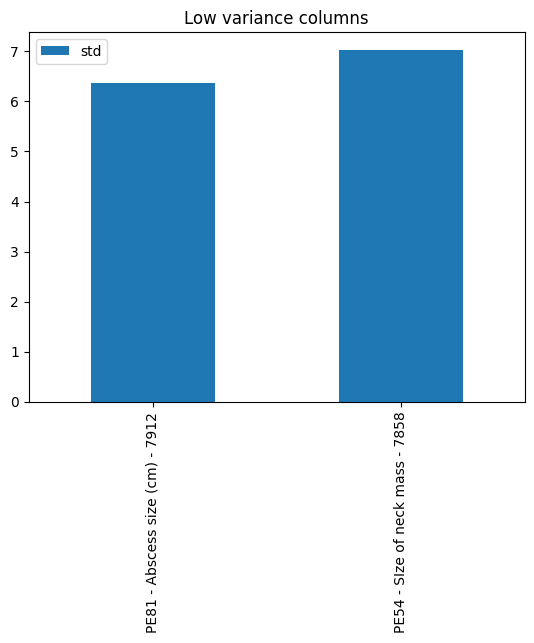

In [5]:
description_rw_symptoms = rw_symptoms.describe()
description_rw_symptoms 

# check for low variance columns
low_var_threshold = 10 # TODO should be different for binary columns
var_rw_data = description_rw_symptoms.loc[["std"]].transpose().dropna().sort_values(by=["std"])

# plot low variance columns
var_rw_data[var_rw_data["std"] <= low_var_threshold].plot(kind="bar", rot=90, title="Low variance columns")

## Missingness

group
(-0.001, 1.0]     24
(1.0, 10.0]        0
(10.0, 20.0]       0
(20.0, 30.0]       0
(30.0, 40.0]       4
(40.0, 50.0]       0
(50.0, 60.0]       1
(60.0, 70.0]       5
(70.0, 80.0]       0
(80.0, 90.0]       7
(90.0, 100.0]    133
dtype: int64


<AxesSubplot:title={'center':'Number of columns per NAN value amount category'}, xlabel='group'>

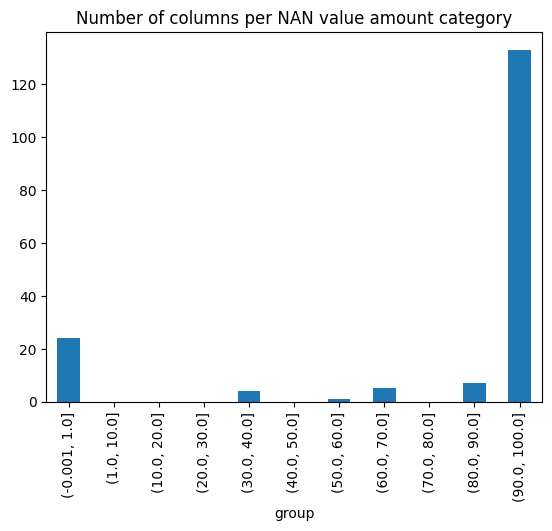

In [6]:
# number of nan per column
nnan_rw_symptoms = rw_symptoms.isnull().sum(axis = 0).to_frame(name="nnan").sort_values("nnan", ascending=False)
nnan_rw_symptoms["nnan_share_in_%"] = nnan_rw_symptoms["nnan"] / rw_symptoms.shape[0] * 100
nnan_rw_symptoms["group"] = pd.cut(nnan_rw_symptoms["nnan_share_in_%"], bins=[0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], right=True, include_lowest=True)
print(nnan_rw_symptoms.groupby("group").size())
nnan_rw_symptoms.groupby("group").size().plot(kind="bar", title="Number of columns per NAN value amount category")

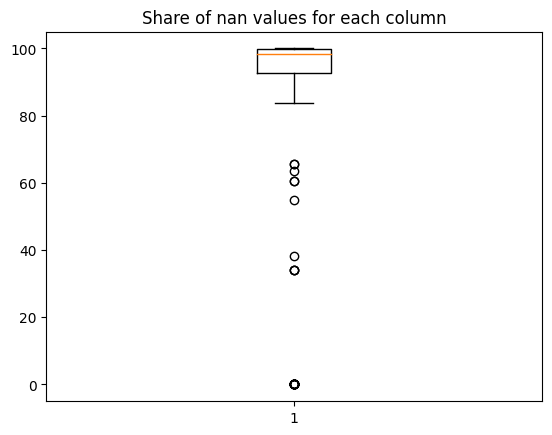

In [7]:
# boxplot of share of nan values for each column
plt.boxplot(nnan_rw_symptoms["nnan_share_in_%"])
plt.title("Share of nan values for each column")
plt.show()

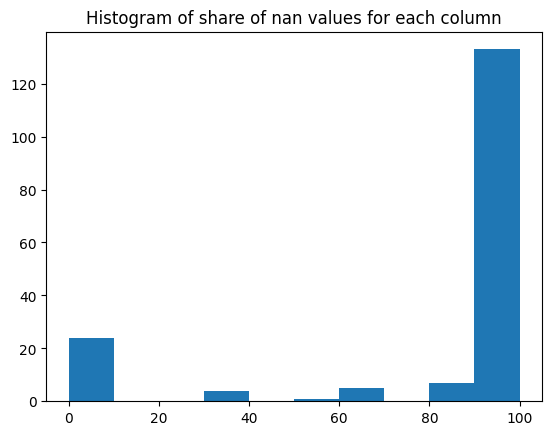

In [8]:
# distribution of share of nan values for each column
plt.hist(nnan_rw_symptoms["nnan_share_in_%"])
plt.title("Histogram of share of nan values for each column")
plt.show()

In [9]:
# columns with no nan
print(nnan_rw_symptoms[nnan_rw_symptoms["nnan"] == 0].size/nnan_rw_symptoms.size*100, "%", "of columns contain no NaN values!")
nnan_rw_symptoms[nnan_rw_symptoms["nnan"] == 0].index

13.793103448275861 % of columns contain no NaN values!


Index(['CC23 - Yellow appearing skin or eyes (jaundice) - 7351',
       'CC30 - Malformation of birth anomaly - 7389',
       'CC33 - Fever or convulsions or lethargy - 7391',
       'CC22 - General Assessment - 8352',
       'CC31 - Injuries (birth and non-birth related) - 7977',
       'CC11 - Eye - 7803',
       'CC13 - Respiratory (Cough or difficult breathing) - 7808',
       'CC27 - Eye complaint - 8066', 'CC26 - Skin - 8073',
       'CC28 - Ear or mouth complaint - 8072',
       'CC17 - Gastrointestinal (diarrhea, vomiting, feeding) - 7875',
       'CC35 - Other - 8120',
       'CC25 - Diarrhea, abdominal, gastro-intestinal - 8076',
       'CC32 - Fever - 8081', 'CC12 - Ear/Throat/Mouth - 8342',
       'CC18 - Accident /Muskulo-skeletal (incl. burns, wounds, poison) - 8343',
       'CC29 - Feeding problem or weight concern - 8347',
       'CC24 - Respiratory - 8370', 'CC15 - Genitourinary (UTI, STI) - 8371',
       'CC16 - Neuro (Headache, stiff neck, neck pain) - 8372',
       

13.793103448275861 % of columns contain less or equal than 20 % of NaN values!


<AxesSubplot:title={'center':'Columns with less or equal than 20% of NaN values'}>

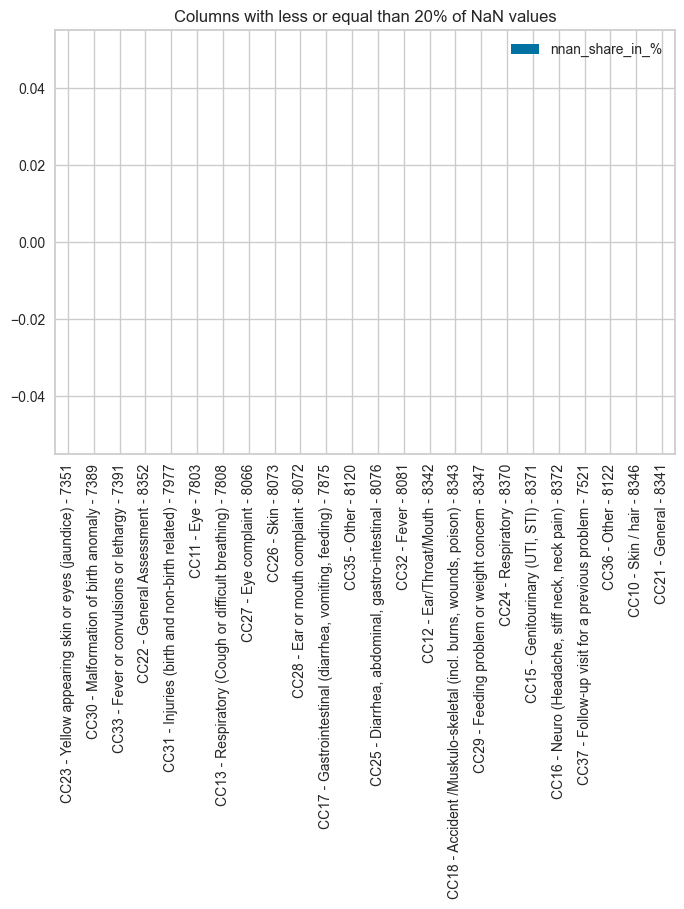

In [27]:
# plot columns with too many NaN values
nnan_threshold = 20 # in %
print(nnan_rw_symptoms[nnan_rw_symptoms["nnan"] / nnan_rw_symptoms.shape[0] * 100 <= nnan_threshold].shape[0] / nnan_rw_symptoms.shape[0] * 100, "%", "of columns contain less or equal than", nnan_threshold,"%", "of NaN values!")
nnan_rw_symptoms[nnan_rw_symptoms["nnan"] / nnan_rw_symptoms.shape[0] * 100 <= nnan_threshold].plot(kind="bar", y="nnan_share_in_%", rot=90, title=f"Columns with less or equal than {nnan_threshold}% of NaN values")

# Data Cleaning

In [11]:
# convert "yes"/"no" columns to floats
rw_symptoms = rw_symptoms.apply(lambda x : x.map({"Yes": 1, "No": 0}), axis=1)

In [19]:
# convert "patient_gender" column into numeric binary column
rw_data["patient_gender"] = [1 if gender == "female" else 0 for gender in rw_data["patient_gender"]]

In [12]:
# drop columns with too many NaN values based on nnan_threshold
#TODO

# print list of columns dropped because of this cleaning step

In [13]:
# replace NaN values with 0 = False = No (TODO how to handle missingness needs to be discussed with ML and domain expert)

# Clustering

## K-Means

Note: K-Means is used as it is currently the best approach of all clustering of symptoms done at IGH.

In [14]:
!pip install yellowbrick

You should consider upgrading via the 'C:\Users\sidla\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [15]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [20]:
# Configuration for KMeans
KMeans_with_NAN_values = True
KMeans_with_symptoms_and_demographic = True

if KMeans_with_NAN_values:
    # convert NAN to 0 indicating that the symptom was not present
    data = rw_symptoms.fillna(0)
else:
    # drop columns which contain NAN values
    data = rw_symptoms.dropna(axis=1)
    print("Dropping columns with NAN, leads to", rw_symptoms.shape[1]-data.shape[1],"less columns.")
    print(data.shape[1], "columns are used for clustering.")

if KMeans_with_symptoms_and_demographic:
    data = pd.merge(data, rw_data[demographic_columns], left_index=True, right_index=True)

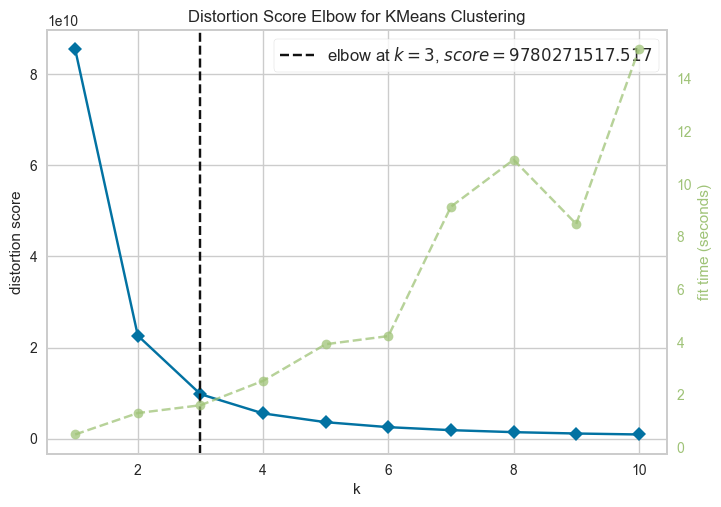

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
# Finding the optimal number of clusters using the Elbow method with yellowbrick
model = KMeans(n_init =10)
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(data)
n_clusters = visualizer.elbow_value_ # optimal number of clusters
visualizer.show()

In [22]:
# Performing clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(data)

# Adding the column 'cluster' to the dataframe
data["cluster"] = kmeans.labels_

<AxesSubplot:title={'center':'Number of consultations per cluster'}, xlabel='cluster'>

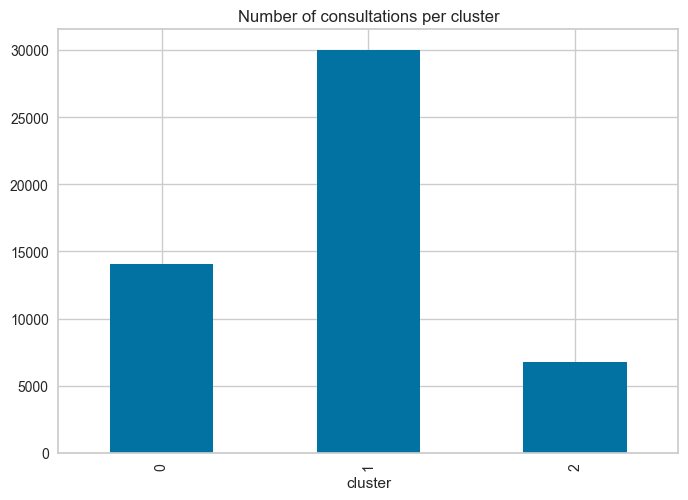

In [23]:
data.groupby("cluster").size().plot(kind="bar", title="Number of consultations per cluster")

# Spatio-temporal analysis of clusters
- spatial dimension = patient's origin (or hf location)
- temporal dimension = consultation date

Reveal:
1. number of consultations in clusters over time and space
2. demographic (age and gender) in cluster over time and space
3. symptom composition in clusters over time and space
4. diagnosis composition in clusters over time and space (Did clustering lead to  or end of the branches of the underlying decision tree of CDSS?)

In [24]:
# TODO engineer final data set with columns 
# key: consultation_date, village_name, village_long, village_lat, 
# number_consultations, age_avg, female_percentage, 
# number of 1 in symptom columns
# number of 1 in diagnosis columns